# Diversity of Ideas: Harvard


## 1. Setup


In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [46]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')
nltk.download('punkt_tab')
from util.ouraws import (
    getFromFile
)

[nltk_data] Downloading package punkt to /Users/pmui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/pmui/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
%pwd

'/Users/pmui/SynologyDrive/research/diversity-ideas/notebooks/2024'

In [4]:
op_eds_df = getFromFile("../../data/harvard-op-eds.parquet", False)
editorials_df = getFromFile("../../data/harvard-editorials.parquet", False)
columns_df = getFromFile("../../data/harvard-columns.parquet", False)

df = pd.concat([op_eds_df, editorials_df, columns_df], ignore_index=True)
df.shape


(8672, 6)

In [5]:
df.shape, op_eds_df.shape, editorials_df.shape, columns_df.shape

((8672, 6), (3026, 6), (2055, 6), (3591, 6))

In [6]:
df.head(4)

,title,url,body,year,month,day
0,"Allston Is Gentrifying, but Harvard Isn’t To B...",https://www.thecrimson.com/article/2024/3/7/be...,"Allston Is Gentrifying, but Harvard Isn’t To B...",2024,3,1
1,Datamatch’s Flaws Run Deeper Than a Leak,https://www.thecrimson.com/article/2024/3/6/ra...,Datamatch’s Flaws Run Deeper Than a Leak\nBy T...,2024,3,1
2,"This Women’s History Month, I Find Myself in G...",https://www.thecrimson.com/article/2024/3/8/ch...,"This Women’s History Month, I Find Myself in G...",2024,3,1
3,A Safer River Run is a Better River Run,https://www.thecrimson.com/article/2024/3/5/me...,A Safer River Run is a Better River Run\nBy Ju...,2024,3,1


## 2. Function Definitions


In [7]:
import numpy as np
import re

In [8]:
def getCovDispersion(wv):
    """
    Calculate various dispersion measures using the covariance matrix of word vectors.
    
    Args:
        wv: numpy array of shape (n_documents, embedding_dim) containing document embeddings
        
    Returns:
        tuple containing:
        - N: number of documents
        - trace_norm: average variance along the diagonal
        - l1_norm: L1 norm of covariance matrix (normalized)
        - l2_norm: L2 norm of covariance matrix (normalized)
        - inf_norm: Infinity norm of covariance matrix (normalized)
    """
    # Get number of documents
    N = len(wv)
    
    # Calculate covariance matrix of the word vectors
    # This measures how dimensions vary together across documents
    cov = np.cov(wv)
    
    return (
        N,  # Number of documents
        np.trace(cov)/N,  # Average variance along diagonal (spread in each dimension)
        np.linalg.norm(cov, ord=1)/N,  # L1 norm (sum of absolute values)
        np.linalg.norm(cov, ord=2)/N,  # L2/Spectral norm (largest singular value)
        np.linalg.norm(cov, ord=np.inf)/N,  # Infinity norm (max absolute row sum)
    )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [9]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [10]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /Users/pmui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [12]:
diversity_pattern = "|".join(diversity_lemmas)

Let's verify how the "count" of diversity words in the text is calculated.


In [13]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

### Cynicism related declarations


In [84]:
# Define LIWC-style categories for cynicism analysis
liwc_cynicism = {
    "skepticism": {"skeptical", "doubtful", "unconvinced", "uncertain", "wary", "dubious"},
    "mistrust": {"untrustworthy", "suspicious", "distrustful", "unreliable", "shady", "rigged", "lying"},
    "questionable": {"questionable", "dubious", "problematic", "concerning", "suspect"},
    "dishonesty": {"dishonest", "lie", "lying", "deceptive", "misleading", "false", "fake"},
    "manipulation": {"manipulative", "coercive", "exploitative", "calculated", "scheming"},
    "corruption": {"corrupt", "bribed", "compromised", "unethical", "crooked", "lying"},
    "negativity": {"bad", "worse", "worst", "terrible", "awful", "disastrous", "weird"},
    "certainty": {"obviously", "definitely", "certainly", "undoubtedly", "absolutely", "clearly"}
}

liwc_cynicism_keys = [key for key in liwc_cynicism if key != "certainty"]
liwc_cynicism_keys

['skepticism',
 'mistrust',
 'questionable',
 'dishonesty',
 'manipulation',
 'corruption',
 'negativity']

In [81]:
def liwc_analysis(text):
    """Analyze text using LIWC-style categories for cynicism."""
    tokens = [token.lower() for token in word_tokenize(text) 
              if token.isalnum()]  # Only include alphanumeric tokens
    word_counts = Counter(tokens)
    total_words = sum(word_counts.values())
    
    # Initialize scores dict with all categories
    liwc_scores = {category: 0 for category in liwc_cynicism.keys()}
    
    # Count matches for each category
    for category, words in liwc_cynicism.items():
        category_count = sum(word_counts[word] for word in words if word in word_counts)
        if total_words > 0:
            liwc_scores[category] = round(category_count / total_words, 4)
    
    # Debug print
    # print("LIWC categories found:", list(liwc_scores.keys()))
    
    return liwc_scores

In [71]:
def compute_cynicism_score(row):
    """Compute cynicism score from LIWC categories."""
    # Create a set of categories excluding 'certainty'
    cynicism_categories = set(liwc_cynicism.keys()) - {'certainty'}
    certainty_weight = 1
    
    # Debug print
    # print("Available columns:", row.index.tolist())
    # print("Looking for categories:", list(cynicism_categories))
    
    # Check if all required categories exist
    missing_categories = [cat for cat in cynicism_categories if cat not in row.index]
    if missing_categories:
        print(f"Missing categories: {missing_categories}")
        return 0.0
    
    try:
        cynicism_score = (sum(row[category] for category in cynicism_categories) - 
                         certainty_weight * row["certainty"]) / len(cynicism_categories)
        return round(cynicism_score, 4)
    except Exception as e:
        print(f"Error computing cynicism score: {e}")
        print(f"Row data: {row}")
        return 0.0

In [83]:
def cronbach_alpha(df):
    """Compute Cronbach's Alpha for internal consistency of LIWC categories."""
    # items = df[liwc_cynicism_keys]
    items = df[liwc_cynicism.keys()]
    item_vars = items.var(axis=0, ddof=1)
    total_var = items.sum(axis=1).var(ddof=1)
    n = items.shape[1]
    return (n / (n - 1)) * (1 - sum(item_vars) / total_var)

## 3. Diversity Analysis


In [14]:
from openai import OpenAI
from typing import List
import numpy as np
client = OpenAI()

In [72]:
def get_embedding(text: str) -> List[float]:
    """
    Get embeddings for a single text using text-embedding-3-large model.
    
    Args:
        text (str): The input text to generate embeddings for
        
    Returns:
        List[float]: The embedding vector
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text,
        dimensions=1024  # Optional: You can specify 256, 512, or 1024 dimensions
    )
    return response.data[0].embedding

def get_batch_embeddings(texts: List[str]) -> List[List[float]]:
    """
    Get embeddings for multiple texts in a single API call.
    
    Args:
        texts (List[str]): List of input texts to generate embeddings for
        
    Returns:
        List[List[float]]: List of embedding vectors
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=texts,
        dimensions=1024
    )
    return [item.embedding for item in response.data]

In [16]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/pmui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    # Step 1: Clean and normalize each text in the series
    # - Convert to lowercase
    # - Lemmatize each word (convert to base form)
    # - Remove stopwords
    # - Join words back together with spaces
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    
    # Step 2: Filter out short texts
    # Remove any text less than 100 characters as they're likely too short for meaningful analysis
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    
    # Step 3: Remove any null values created by the previous step
    text_series = text_series.dropna()
    
    # Step 4: Count diversity-related terms
    # Sum up all instances of diversity-related words (defined in diversity_pattern)
    # across all remaining texts in the series
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    
    # Return both the cleaned text series and the total count of diversity words
    return text_series, total_diversity_words

In [18]:
START_YEAR = 2009
FINAL_YEAR = 2024

In [19]:
year_2024 = df[df.year==2024]
clean_df, num_diversity_words = prepText(year_2024.body)
wv = get_batch_embeddings(clean_df)

In [20]:
type(wv[0])

list

In [21]:
docmatrix = np.array(wv)

In [22]:
docmatrix.shape

(439, 1024)

In [23]:
pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
cov = getCovDispersion(docmatrix)
print(f"{year_2024.year}, {cov[0]}, {cov[1]}, {pairwise}")

0       2024
1       2024
2       2024
3       2024
4       2024
        ... 
8224    2024
8226    2024
8229    2024
8230    2024
8232    2024
Name: year, Length: 443, dtype: int64, 439, 0.0009771119536240679, 0.4183325139368315


In [35]:
# VADER Sentiment Analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pmui/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [63]:
def chunk_process_embeddings(clean_df):
    """
    Process embeddings in chunks and combine results.
    
    Args:
        clean_df: pandas Series of cleaned text
    
    Returns:
        List of embeddings
    """
    # Calculate chunk size (divide into 3 equal parts)
    chunk_size = len(clean_df) // 3
    
    # Split into 3 chunks
    chunks = [
        clean_df[i:i + chunk_size] 
        for i in range(0, len(clean_df), chunk_size)
    ]
    
    # Process each chunk and combine results
    all_embeddings = []
    for chunk in chunks:
        chunk_embeddings = get_batch_embeddings(chunk)
        all_embeddings.extend(chunk_embeddings)
    
    return all_embeddings

In [85]:
results = []
print(f"{'year':<12}{'size':<12}{'trace':<12}{'pairwise':<12}{'vader':<12}{'lexical':<12}{'alpha':<12}")
print("-"*78)
LIWC_SCORE_NAME = "cinicism_lexical"
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = chunk_process_embeddings(clean_df)
    
    docmatrix = np.array(wv)
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    # -------------- VADER: Sentiment Analysis ----------------- #
    pos_scores = []
    neg_scores = []
    neu_scores = []
    compound_scores = []
    
    for text in clean_df:
        sentiment_scores = sia.polarity_scores(text)
        pos_scores.append(sentiment_scores['pos'])
        neg_scores.append(sentiment_scores['neg'])
        neu_scores.append(sentiment_scores['neu'])
        compound_scores.append(sentiment_scores['compound']) 
 
    # --------------- LIWC: Lexical Analysis -------------------- #
    temp_df = clean_df.copy()
    
    # Apply LIWC analysis and convert results to separate columns
    liwc_scores = temp_df.apply(liwc_analysis)

    # Convert the series of dictionaries to a DataFrame
    liwc_columns = pd.DataFrame.from_records(liwc_scores.values)
    
    # Combine with original DataFrame
    temp_df = pd.DataFrame(temp_df, columns=['text'])
    liwc_df = pd.concat([temp_df, liwc_columns], axis=1)
    alpha = cronbach_alpha(liwc_df)
    
    # Calculate cynicism score
    liwc_df[LIWC_SCORE_NAME] = liwc_df.apply(compute_cynicism_score, axis=1)
    sum_liwc_score = liwc_df[LIWC_SCORE_NAME].sum()
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0],
              'pos': sum(pos_scores) / len(pos_scores),
              'neg': sum(neg_scores) / len(neg_scores),
              'neu': sum(neu_scores) / len(neu_scores),
              'vader': sum(compound_scores) / len(compound_scores),
              'lexical': sum_liwc_score,
              'alpha': alpha
    }
    results.append(result)
    
    print(f"{year:<12}{cov[0]:<12}{cov[1]:<12.3f}{pairwise:<12.3f}{result['vader']:<12.3f}{result['lexical']:<12.3f}{result['alpha']:<12.3f}")

year        size        trace       pairwise    vader       lexical     alpha       
------------------------------------------------------------------------------
2009        206         0.001       0.572       0.619       0.015       0.131       
2010        599         0.001       0.582       0.588       0.040       0.183       
2011        566         0.001       0.550       0.584       0.042       0.116       
2012        557         0.001       0.534       0.530       0.052       0.119       
2013        690         0.001       0.563       0.507       0.100       0.268       
2014        686         0.001       0.569       0.549       0.100       0.215       
2015        579         0.001       0.563       0.440       0.065       0.123       
2016        530         0.001       0.543       0.522       0.073       0.164       
2017        523         0.001       0.526       0.574       0.077       0.218       
2018        538         0.001       0.522       0.570       0.086      

In [86]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm,pos,neg,neu,vader,lexical,alpha
year,,,,,,,,,,,,,,
2009,0.572057,206,0.000977,0.000508,0.000425,0.000508,48,0.233010,0.168583,0.105626,0.725709,0.619253,0.0148,0.130839
2010,0.581804,599,0.000977,0.000509,0.000414,0.000509,234,0.390651,0.171805,0.099543,0.728629,0.588481,0.0397,0.183163
2011,0.549663,566,0.000977,0.000551,0.000446,0.000551,283,0.500000,0.168261,0.096171,0.735539,0.583645,0.0418,0.115967
2012,0.533616,557,0.000977,0.000543,0.000461,0.000543,311,0.558348,0.171399,0.106190,0.722388,0.529646,0.0522,0.118745
2013,0.562968,690,0.000977,0.000535,0.000433,0.000535,249,0.360870,0.172081,0.108519,0.719406,0.506646,0.0995,0.268180
2014,0.569431,686,0.000977,0.000538,0.000429,0.000538,282,0.411079,0.170410,0.100771,0.728818,0.549153,0.0997,0.215366
2015,0.563370,579,0.000977,0.000546,0.000436,0.000546,444,0.766839,0.165209,0.111857,0.722896,0.440314,0.0647,0.123012
2016,0.543445,530,0.000977,0.000578,0.000455,0.000578,424,0.800000,0.170243,0.105526,0.724221,0.522388,0.0734,0.164228
2017,0.526137,523,0.000977,0.000560,0.000471,0.000560,531,1.015296,0.166086,0.100717,0.733218,0.573774,0.0772,0.217663


### Regress Goodness of Fit: Pairwise Dispersion


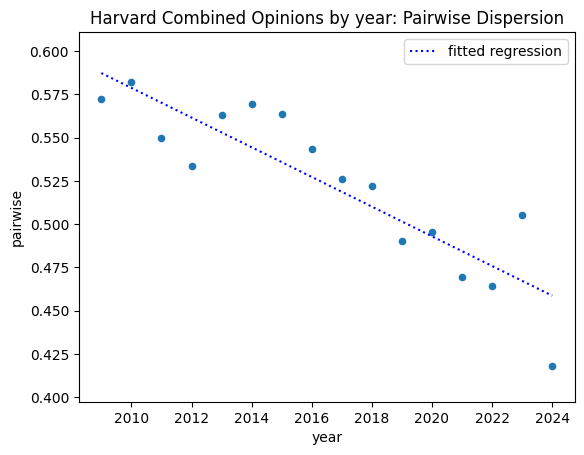

In [87]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Harvard Combined Opinions by year: Pairwise Dispersion")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

### Regress Goodness of Fit: VADER Sentiment Analysis


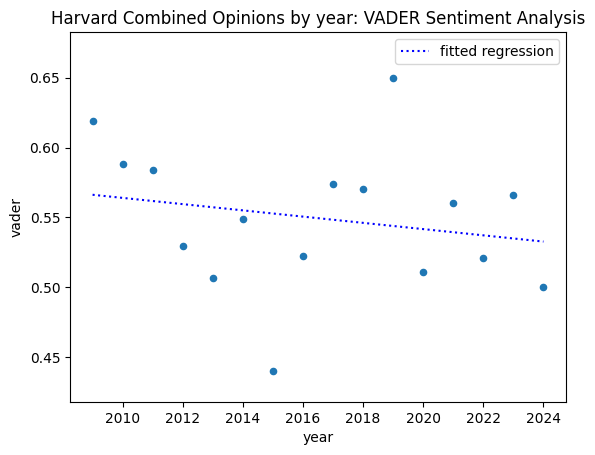

In [88]:
x = results_df['year']
y = results_df['vader']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="vader", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Harvard Combined Opinions by year: VADER Sentiment Analysis")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

### Regress Goodness of Fit: LIWC Lexical Analysis


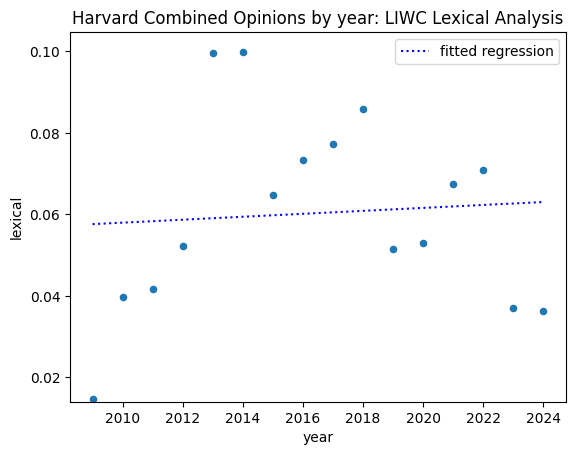

In [89]:
x = results_df['year']
y = results_df['lexical']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="lexical", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Harvard Combined Opinions by year: LIWC Lexical Analysis")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

## Combined Diversity and Sentiment Analyses



mentions-norm metrics:
  slope: 0.05080
  95% CI: (0.03329, 0.06832)
  std error: 0.00817
  p-value: 0.00002
  r-value: 0.85692

pairwise metrics:
  slope: -0.00857
  95% CI: (-0.01116, -0.00598)
  std error: 0.00121
  p-value: 0.00001
  r-value: -0.88471

vader metrics:
  slope: -0.00223
  95% CI: (-0.00821, 0.00375)
  std error: 0.00279
  p-value: 0.43682
  r-value: -0.20920

lexical metrics:
  slope: 0.00036
  95% CI: (-0.00250, 0.00323)
  std error: 0.00134
  p-value: 0.79055
  r-value: 0.07217


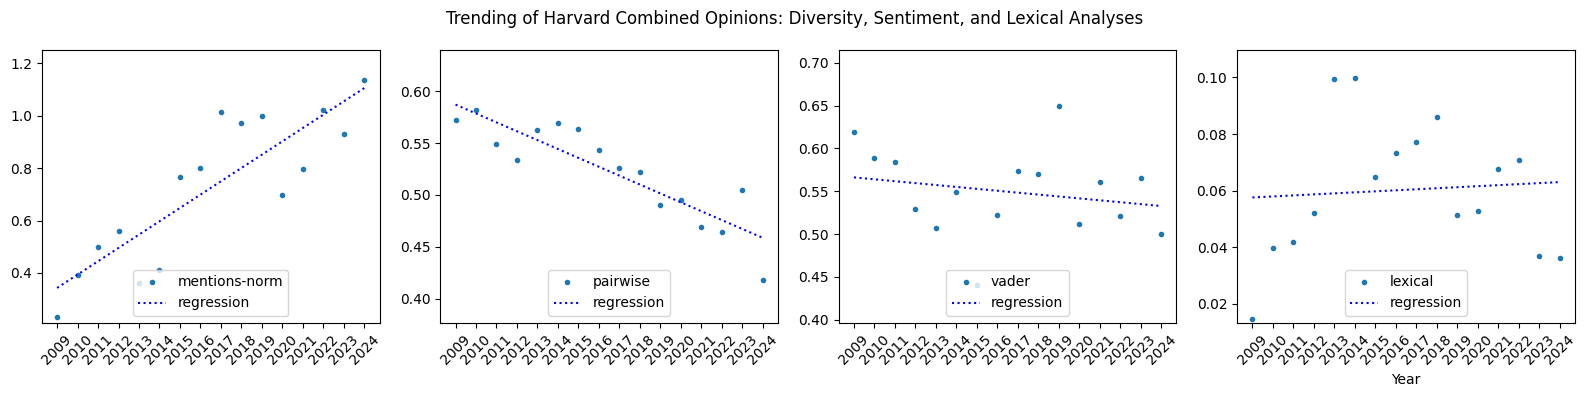

In [90]:
from scipy.stats import t

# Select the columns to plot
columns = ["mentions-norm", "pairwise", "vader", "lexical"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Calculate 95% confidence interval
    confidence_level = 0.95
    degrees_of_freedom = len(x) - 2
    t_value = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)
    margin_of_error = t_value * std_err
    ci_lower = slope - margin_of_error
    ci_upper = slope + margin_of_error
    
    # Print comprehensive statistics
    print(f"\n{column} metrics:")
    print(f"  slope: {slope:.5f}")
    print(f"  95% CI: ({ci_lower:.5f}, {ci_upper:.5f})")
    print(f"  std error: {std_err:.5f}")
    print(f"  p-value: {p_value:.5f}")
    print(f"  r-value: {r_value:.5f}")

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(min(y)*0.9, max(y)*1.1)
    # ax.set_ylim(0.0, 1.0)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    ax.tick_params(axis='x', rotation=45)
    
plt.xlabel("Year")
plt.suptitle("Trending of Harvard Combined Opinions: Diversity, Sentiment, and Lexical Analyses")
plt.tight_layout()
plt.show()

In [30]:
from scipy.stats import t, linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

confidence_level = 0.95
degrees_of_freedom = len(x) - 2
t_value = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

margin_of_error = t_value * std_err

ci_lower = slope - margin_of_error
ci_upper = slope + margin_of_error

print(f"Slope: {slope:.5f}")
print(f"95% Confidence Interval: ({ci_lower:.5f}, {ci_upper:.5f})")
print(f"Standard Error: {std_err:.5f}")
print(f"P-value: {p_value:.5f}")

Slope: -0.00857
95% Confidence Interval: (-0.01116, -0.00598)
Standard Error: 0.00121
P-value: 0.00001


## 4. VADER Sentiment Analysis

First, you need to install the VADER sentiment analysis tool. If you're using Python, you can install it with the nltk (Natural Language Toolkit) library.


In [31]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pmui/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Analyze the Sentiment of Text:**

Once you have the SentimentIntensityAnalyzer instance, you can use the .polarity_scores() method to analyze the sentiment of a given text. This method returns a dictionary with the following scores:

- positive: A score for the positive sentiment.
- neutral: A score for the neutral sentiment.
- negative: A score for the negative sentiment.
- compound: The overall sentiment score, which is a normalized value between -1 (most negative) and +1 (most positive).


In [32]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    # wv = get_batch_embeddings(clean_df)

    # Calculate sentiment scores for each text and average them
    pos_scores = []
    neg_scores = []
    neu_scores = []
    compound_scores = []
    
    for text in clean_df:
        sentiment_scores = sia.polarity_scores(text)
        pos_scores.append(sentiment_scores['pos'])
        neg_scores.append(sentiment_scores['neg'])
        neu_scores.append(sentiment_scores['neu'])
        compound_scores.append(sentiment_scores['compound'])
    
    result = {'year': year,
              'pos': sum(pos_scores) / len(pos_scores),
              'neg': sum(neg_scores) / len(neg_scores),
              'neu': sum(neu_scores) / len(neu_scores),
              'compound': sum(compound_scores) / len(compound_scores)}
    
    results.append(result)

In [33]:
for result in results:
    print(f"year: {result['year']}, pos: {result['pos']:.2f}, neg: {result['neg']:.2f}, neu: {result['neu']:.2f}, compound: {result['compound']:.2f}")

year: 2009, pos: 0.17, neg: 0.11, neu: 0.73, compound: 0.62
year: 2010, pos: 0.17, neg: 0.10, neu: 0.73, compound: 0.59
year: 2011, pos: 0.17, neg: 0.10, neu: 0.74, compound: 0.58
year: 2012, pos: 0.17, neg: 0.11, neu: 0.72, compound: 0.53
year: 2013, pos: 0.17, neg: 0.11, neu: 0.72, compound: 0.51
year: 2014, pos: 0.17, neg: 0.10, neu: 0.73, compound: 0.55
year: 2015, pos: 0.17, neg: 0.11, neu: 0.72, compound: 0.44
year: 2016, pos: 0.17, neg: 0.11, neu: 0.72, compound: 0.52
year: 2017, pos: 0.17, neg: 0.10, neu: 0.73, compound: 0.57
year: 2018, pos: 0.17, neg: 0.10, neu: 0.74, compound: 0.57
year: 2019, pos: 0.17, neg: 0.10, neu: 0.73, compound: 0.65
year: 2020, pos: 0.17, neg: 0.11, neu: 0.73, compound: 0.51
year: 2021, pos: 0.17, neg: 0.10, neu: 0.73, compound: 0.56
year: 2022, pos: 0.16, neg: 0.11, neu: 0.73, compound: 0.52
year: 2023, pos: 0.16, neg: 0.10, neu: 0.74, compound: 0.57
year: 2024, pos: 0.16, neg: 0.10, neu: 0.74, compound: 0.50


Regression results:
Slope: -0.0022 (change in compound score per year)
R-squared: 0.0438
P-value: 0.4368


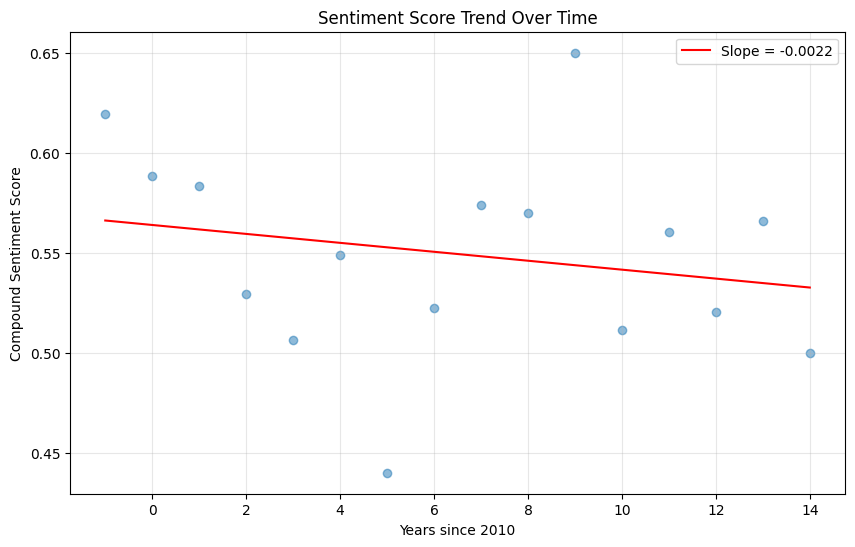

In [34]:
import numpy as np
from scipy import stats

# First convert results list to a DataFrame for easier manipulation
results_df = pd.DataFrame(results)

# Create array of years since 2010
base_year = 2010
years_since_2010 = results_df['year'] - base_year

# Get compound scores
compound_scores = results_df['compound']

# Calculate regression
slope, intercept, r_value, p_value, std_err = stats.linregress(years_since_2010, compound_scores)

print(f"Regression results:")
print(f"Slope: {slope:.4f} (change in compound score per year)")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

# Optional: Plot the regression line
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(years_since_2010, compound_scores, alpha=0.5)
plt.plot(years_since_2010, intercept + slope * years_since_2010, 'r', 
         label=f'Slope = {slope:.4f}')
plt.xlabel('Years since 2010')
plt.ylabel('Compound Sentiment Score')
plt.title('Sentiment Score Trend Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()